In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
import os
import statsmodels.api as sm
from matplotlib import pylab
import pylab as pl

In [2]:
data= pd.read_csv('data1 (1).csv')

In [3]:
data

Churn  utilization  Age  Num_loans  Num_dependents  MonthlyIncome  \
0           1     0.766127   45          6               2           9120   
1           0     0.957151   40          0               1           4600   
2           0     0.658180   38          0               0           5042   
3           0     0.233810   30          0               0           5300   
4           0     0.907239   49          1               0           6357   
...       ...          ...  ...        ...             ...            ...   
149995      0     0.299745   44          1               2           7584   
149996      0     0.246044   58          1               0           6357   
149997      0     0.000000   30          0               0           7716   
149998      0     0.850283   64          2               0          10158   
149999      0     0.651603   58          1               0           9783   

        Num_Savings_Acccts  DebtRatio  
0                        2   0.852982  
1                        2   0.121876  
2                        2   0.085113  
3                        2   0.036050  
4                        2   0.024926  
...                    ...        ...  
149995                   2   0.716562  
149996                   2   0.274502  
149997                   2   0.000000  
149998                   2   0.249908  
149999                   2   0.241136  

[150000 rows x 8 columns]

In [7]:
data.head()

Churn  utilization  Age  Num_loans  Num_dependents  MonthlyIncome  \
0      1     0.766127   45          6               2           9120   
1      0     0.957151   40          0               1           4600   
2      0     0.658180   38          0               0           5042   
3      0     0.233810   30          0               0           5300   
4      0     0.907239   49          1               0           6357   

   Num_Savings_Acccts  DebtRatio  
0                   2   0.852982  
1                   2   0.121876  
2                   2   0.085113  
3                   2   0.036050  
4                   2   0.024926

In [12]:
def iv_woe(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()
    
    #Extract Column Names
    cols = data.columns
    
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)
    return newDF, woeDF

In [13]:
iv, woe = iv_woe(data = data, target = 'Churn', bins=10, show_woe = True)
print(iv)
print(woe)

iv = pd.DataFrame(iv)
iv.sort_values(["IV"],ascending=[0])

Information value of utilization is 0.968186
      Variable             Cutoff      N  Events  % of Events  Non-Events  \
0  utilization  (-0.001, 0.00297]  15000     378     0.037702       14622   
1  utilization  (0.00297, 0.0192]  15000     204     0.020347       14796   
2  utilization   (0.0192, 0.0435]  15000     210     0.020946       14790   
3  utilization   (0.0435, 0.0832]  15000     287     0.028626       14713   
4  utilization    (0.0832, 0.154]  15000     356     0.035508       14644   
5  utilization     (0.154, 0.272]  15000     521     0.051965       14479   
6  utilization     (0.272, 0.401]  15000    1804     0.179932       13196   
7  utilization     (0.401, 0.635]  15000    1195     0.119190       13805   
8  utilization     (0.635, 0.931]  15000    2150     0.214442       12850   
9  utilization       (0.931, 1.0]  15000    2921     0.291343       12079   

   % of Non-Events       WoE        IV  
0         0.104462 -1.019113  0.068036  
1         0.105705 -1.647

Variable        IV
0       MonthlyIncome  1.590980
0           DebtRatio  1.557476
0         utilization  0.968186
0                 Age  0.259166
0      Num_dependents  0.024965
0           Num_loans  0.012091
0  Num_Savings_Acccts  0.000916

In [14]:
def outlier (data,age):
 Q1 = data[age].quantile(0.25)
 Q3 = data[age].quantile(0.75)
 IQR = Q3 - Q1
 data= data.loc[~((data[age] < (Q1 - 1.5 * IQR)) | (data[age] > (Q3 + 1.5 * IQR))),]
 return data

In [17]:
data.boxplot(column=["Age"])

<AxesSubplot:>

In [16]:
data = outlier(data,"Age")

In [18]:
data.boxplot(column=["Age"])

<AxesSubplot:>

In [19]:
data.boxplot(column=["utilization"])

<AxesSubplot:>

In [20]:
data = data.dropna()

In [21]:
data.isnull().sum()

Churn                 0
utilization           0
Age                   0
Num_loans             0
Num_dependents        0
MonthlyIncome         0
Num_Savings_Acccts    0
DebtRatio             0
dtype: int64

In [22]:
train_cols = data.loc[:,["utilization","Age","Num_loans",
"Num_dependents","MonthlyIncome","Num_Savings_Acccts","DebtRatio"]]

train_cols.head()

utilization  Age  Num_loans  Num_dependents  MonthlyIncome  \
0     0.766127   45          6               2           9120   
1     0.957151   40          0               1           4600   
2     0.658180   38          0               0           5042   
3     0.233810   30          0               0           5300   
4     0.907239   49          1               0           6357   

   Num_Savings_Acccts  DebtRatio  
0                   2   0.852982  
1                   2   0.121876  
2                   2   0.085113  
3                   2   0.036050  
4                   2   0.024926

In [25]:
train_cols.tail(5)

utilization  Age  Num_loans  Num_dependents  MonthlyIncome  \
149995     0.299745   44          1               2           7584   
149996     0.246044   58          1               0           6357   
149997     0.000000   30          0               0           7716   
149998     0.850283   64          2               0          10158   
149999     0.651603   58          1               0           9783   

        Num_Savings_Acccts  DebtRatio  
149995                   2   0.716562  
149996                   2   0.274502  
149997                   2   0.000000  
149998                   2   0.249908  
149999                   2   0.241136

In [26]:
logit = sm.Logit(data['Churn'], train_cols)
# fit the model
result = logit.fit()
result.summary()#all p values are significant

Optimization terminated successfully.
         Current function value: 0.193200
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  Churn   No. Observations:               149955
Model:                          Logit   Df Residuals:                   149948
Method:                           MLE   Df Model:                            6
Date:                Tue, 27 Jun 2023   Pseudo R-squ.:                  0.2127
Time:                        10:57:33   Log-Likelihood:                -28971.
converged:                       True   LL-Null:                       -36797.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
utilization            1.7383      0.028     61.641      0.000       1.683       1.794
Age                   -0.0201      0.001    -29.881      0.000      -0.021      -0.019
Num_loans              0.2701      0.010     25.735      0.000       0.250       0.291
Num_dependents         0.1751      0.010     18.330      0.000       0.156       0.194
MonthlyIncome         -0.0005   5.54e-06    -85.570      0.000      -0.000      -0.000
Num_Savings_Acccts    -0.0329      0.005     -7.127      0.000      -0.042      -0.024
DebtRatio              0.9474      0.050     19.085      0.000       0.850       1.045
======================================================================================
"""

In [28]:
result.conf_int()

0         1
utilization         1.683053  1.793598
Age                -0.021386 -0.018753
Num_loans           0.249547  0.290691
Num_dependents      0.156369  0.193812
MonthlyIncome      -0.000485 -0.000463
Num_Savings_Acccts -0.041943 -0.023849
DebtRatio           0.850084  1.044670

In [30]:
np.exp(result.params)

utilization           5.687811
Age                   0.980130
Num_loans             1.310120
Num_dependents        1.191354
MonthlyIncome         0.999526
Num_Savings_Acccts    0.967639
DebtRatio             2.578935
dtype: float64

In [31]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor


result=sm.ols(formula="Churn~utilization+Age+Num_loans+Num_dependents+MonthlyIncome+Num_Savings_Acccts+DebtRatio",
             data=data).fit()
result.summary()# shows total summary

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Churn   R-squared:                       0.094
Model:                            OLS   Adj. R-squared:                  0.094
Method:                 Least Squares   F-statistic:                     2220.
Date:                Tue, 27 Jun 2023   Prob (F-statistic):               0.00
Time:                        11:10:07   Log-Likelihood:                 2651.5
No. Observations:              149955   AIC:                            -5287.
Df Residuals:                  149947   BIC:                            -5208.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.1166      0.003     34.132      0.000       0.110       0.123
utilization            0.1470      0.002     75.888      0.000       0.143       0.151
Age                   -0.0006   4.43e-05    -13.040      0.000      -0.001      -0.000
Num_loans              0.0085      0.001     12.684      0.000       0.007       0.010
Num_dependents         0.0110      0.001     18.742      0.000       0.010       0.012
MonthlyIncome      -1.339e-05   1.93e-07    -69.304      0.000   -1.38e-05    -1.3e-05
Num_Savings_Acccts     0.0005      0.000      1.800      0.072   -4.54e-05       0.001
DebtRatio              0.0632      0.004     17.746      0.000       0.056       0.070
==============================================================================
Omnibus:                    90365.302   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           645269.352
Skew:                           2.986   Prob(JB):                         0.00
Kurtosis:                      11.223   Cond. No.                     5.47e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.47e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [32]:
var = pd.DataFrame(round(result.pvalues,3))# shows p value
var["coeff"] = result.params#coefficients
variables = result.model.exog #.if I had saved data as rock
# this it would have looked like rock.model.exog
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]
vif 
var["vif"] = vif
var

0     coeff        vif
Intercept           0.000  0.116641  30.984321
utilization         0.000  0.147024   1.111849
Age                 0.000 -0.000578   1.135128
Num_loans           0.000  0.008503   1.456122
Num_dependents      0.000  0.010994   1.116877
MonthlyIncome       0.000 -0.000013   1.223979
Num_Savings_Acccts  0.072  0.000510   1.000059
DebtRatio           0.000  0.063156   1.335527

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

In [34]:
train_cols = data.loc[:,["utilization","Age","Num_loans",
"Num_dependents","MonthlyIncome","Num_Savings_Acccts","DebtRatio"]]

In [35]:
inputData=train_cols # ind var
outputData=data.loc[:,"Churn"] # dep var

In [36]:
logit1=LogisticRegression()
logit1.fit(inputData,outputData)
logit1.score(inputData,outputData)

y_pred = logit1.predict(train_cols)
prob = logit1.predict_proba(train_cols)

In [38]:
prob = pd.DataFrame(prob)
prob = prob.iloc[:,1]#showing the probability of being 1
prob = prob.reset_index()
prob.head()

index         1
0      0  0.269134
1      1  0.244625
2      2  0.124966
3      3  0.066355
4      4  0.115119

In [39]:
outputData = pd.DataFrame(outputData)
outputData.head()
outputData = outputData.reset_index()
outputData = outputData.iloc[:,1]
outputData.head()

0    1
1    0
2    0
3    0
4    0
Name: Churn, dtype: int64

In [40]:
rock = pd.concat([outputData,prob], axis=1)
rock = rock.iloc[:,[0,2]]#this line might give error, check the column index
rock.head()
df = rock.copy()
df.columns = ["y","p"]
df.head()

y         p
0  1  0.269134
1  0  0.244625
2  0  0.124966
3  0  0.066355
4  0  0.115119

In [41]:
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
confusion_matrix(logit1.predict(inputData),outputData)# this is experimental not required

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(logit1.predict(inputData),outputData))
print(classification_report(logit1.predict(inputData),outputData))

[[139465   8998]
 [   467   1025]]
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    148463
           1       0.10      0.69      0.18      1492

    accuracy                           0.94    149955
   macro avg       0.55      0.81      0.57    149955
weighted avg       0.99      0.94      0.96    149955



In [42]:
##Computing false and true positive rates
fpr, tpr,_=roc_curve(logit1.predict(inputData),outputData,drop_intermediate=False)

In [43]:
import matplotlib.pyplot as plt
plt.figure()

<Figure size 640x480 with 0 Axes>

In [44]:
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')

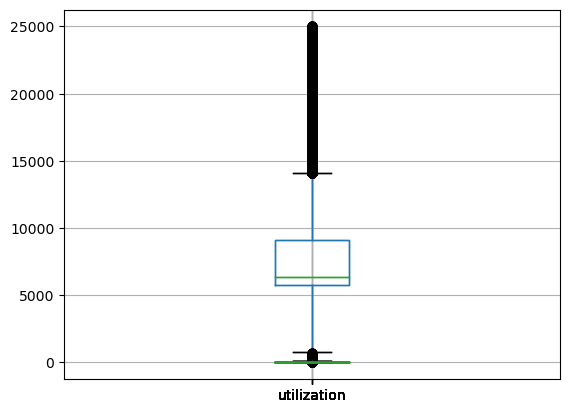

0.8131948127677311

In [45]:
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()
roc_auc_score(logit1.predict(inputData),outputData)